In [121]:
import warnings
warnings.filterwarnings('ignore')

import os

# dataset processing libraries

import pandas as pd
import numpy as np

# model libraries

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss

from catboost import CatBoostClassifier, Pool, cv

# visual data

import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=False)
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 10
plt.style.use('ggplot')
%matplotlib inline

### Read data

In [5]:
df = pd.read_csv('train.csv', index_col='id')
df_test = pd.read_csv('test.csv', index_col='id')

In [6]:
df.head()

Birth date  Native city  Gender  Wave id     Level  \
id                                                              
129212391  1990-01-18        Пермь    male        3  7.463235   
566688420  1996-07-31    Волгоград  female        1  8.785714   
242300495  1992-06-27  Новосибирск  female        2  6.775000   
715424753  1996-06-15         Тула  female        1  8.146104   
382884118  1968-07-18     Голицыно    male        3  4.272727   

          Heard about school from Life status  day_00  day_01  day_02  ...  \
id                                                                     ...   
129212391              google_ads        work       5     NaN     0.0  ...   
566688420                     NaN         NaN       0     NaN    10.0  ...   
242300495                   other        work       0     NaN    20.0  ...   
715424753                     NaN         NaN       5     0.0    35.0  ...   
382884118                   other       other       0     0.0     NaN  ...   

           rush_01  rush_02  exam_00  exam_01  exam_02  exam_final  \
id                                                                   
129212391      0.0      0.0     75.0     43.0    100.0        44.0   
566688420      0.0      0.0      0.0     16.0     22.0        22.0   
242300495      NaN      NaN      0.0      0.0     16.0        27.0   
715424753      0.0      0.0      0.0      0.0     27.0        27.0   
382884118      0.0      0.0     80.0     38.0      0.0        45.0   

           Contract termination date  Memory entrance game  \
id                                                           
129212391                        NaN                     9   
566688420                        NaN                     7   
242300495                        NaN                     7   
715424753                        NaN                     9   
382884118                        NaN                     7   

           Logic entrance game  contract_status  
id                                               
129212391                   11                1  
566688420                   10                1  
242300495                   11                1  
715424753                    6                1  
382884118                   12                1  

[5 rows x 35 columns]

In [7]:
df.columns

Index(['Birth date', 'Native city', 'Gender', 'Wave id', 'Level',
       'Heard about school from', 'Life status', 'day_00', 'day_01', 'day_02',
       'day_03', 'day_04', 'day_05', 'day_06', 'day_07', 'day_08', 'day_09',
       'day_10', 'day_11', 'day_12', 'day_13', 'evalexpr', 'match_n_match',
       'bsq', 'rush_00', 'rush_01', 'rush_02', 'exam_00', 'exam_01', 'exam_02',
       'exam_final', 'Contract termination date', 'Memory entrance game',
       'Logic entrance game', 'contract_status'],
      dtype='object')

In [8]:
df_wave = pd.read_csv('waves_dates.csv')
df_wave['date'] = pd.to_datetime(df_wave['date'].apply(lambda x: x.partition('T')[0]))#.to_dict()['date']
time_waves = dict(zip(df_wave['id'], df_wave['date']))
time_waves

{1: Timestamp('2018-11-19 00:00:00'),
 2: Timestamp('2019-04-01 00:00:00'),
 3: Timestamp('2019-09-02 00:00:00'),
 4: Timestamp('2020-03-31 00:00:00')}

### Describe data (check train and test data)

In [9]:
df.describe()

Wave id        Level       day_00      day_01       day_02  \
count  1060.000000  1060.000000  1060.000000  646.000000  1044.000000   
mean      2.198113     5.886947    25.367925   12.256966    15.074713   
std       0.935299     2.375018    30.061418   23.637618    26.289526   
min       1.000000     0.221239     0.000000    0.000000   -42.000000   
25%       1.000000     4.176471     5.000000    0.000000     0.000000   
50%       2.000000     5.469340    10.000000    0.000000     0.000000   
75%       3.000000     7.553309    40.000000   15.000000    30.000000   
max       4.000000    14.184049   100.000000  100.000000   100.000000   

            day_03       day_04       day_05       day_06       day_07  ...  \
count  1045.000000  1037.000000  1056.000000  1048.000000  1046.000000  ...   
mean     27.494737    21.867888     9.270833    33.533397    12.885277  ...   
std      25.398156    26.438698    16.153897    37.113688    17.813662  ...   
min     -42.000000   -42.000000     0.000000   -42.000000   -42.000000  ...   
25%       5.000000     0.000000     1.000000     0.000000     0.000000  ...   
50%      25.000000    10.000000     3.000000    20.000000    10.000000  ...   
75%      45.000000    40.000000    10.000000    70.000000    25.000000  ...   
max     100.000000   100.000000    91.000000   100.000000   100.000000  ...   

          rush_00     rush_01     rush_02      exam_00      exam_01  \
count  996.000000  944.000000  902.000000  1047.000000  1041.000000   
mean    51.168675   10.325212    7.949002    31.289398    33.119116   
std     55.945645   28.172043   25.447290    35.758769    23.860557   
min      0.000000    0.000000    0.000000     0.000000     0.000000   
25%      0.000000    0.000000    0.000000     0.000000    16.000000   
50%     10.000000    0.000000    0.000000     0.000000    32.000000   
75%    120.000000    0.000000    0.000000    65.000000    48.000000   
max    125.000000  100.000000  110.000000   100.000000   100.000000   

           exam_02   exam_final  Memory entrance game  Logic entrance game  \
count  1047.000000  1056.000000           1060.000000          1060.000000   
mean     46.372493    34.196970              8.145283            11.435849   
std      24.198761    13.976318              1.603121             3.123011   
min       0.000000     0.000000              5.000000             6.000000   
25%      30.000000    27.000000              7.000000            10.000000   
50%      48.000000    35.000000              8.000000            11.000000   
75%      64.000000    40.000000              9.000000            13.000000   
max     100.000000    90.000000             21.000000            24.000000   

       contract_status  
count      1060.000000  
mean          0.866038  
std           0.340773  
min           0.000000  
25%           1.000000  
50%           1.000000  
75%           1.000000  
max           1.000000  

[8 rows x 29 columns]

In [10]:
df_test.describe()

Wave id       Level      day_00      day_01      day_02      day_03  \
count  706.000000  706.000000  706.000000  447.000000  698.000000  700.000000   
mean     2.178470    5.883789   23.906516   12.105145   13.871060   27.088571   
std      0.940434    2.194641   28.855272   22.376520   24.474869   24.272962   
min      1.000000    0.415929    0.000000    0.000000  -42.000000  -42.000000   
25%      1.000000    4.181818    5.000000    0.000000    0.000000    5.000000   
50%      2.000000    5.636792   10.000000    0.000000    0.000000   25.000000   
75%      3.000000    7.397059   36.500000   20.000000   20.000000   42.000000   
max      4.000000   15.083333  100.000000  100.000000  100.000000  100.000000   

           day_04      day_05      day_06      day_07  ...         bsq  \
count  690.000000  704.000000  699.000000  701.000000  ...  688.000000   
mean    22.115942    8.630682   35.530758   12.390870  ...    7.491279   
std     26.583677   16.063529   37.948428   18.015505  ...   26.166134   
min      0.000000  -42.000000  -42.000000  -42.000000  ...  -42.000000   
25%      0.000000    1.000000    0.000000    0.000000  ...    0.000000   
50%     10.000000    2.500000   20.000000   10.000000  ...    0.000000   
75%     40.000000   10.000000   70.000000   20.000000  ...    0.000000   
max    100.000000   83.000000  100.000000  100.000000  ...  100.000000   

          rush_00     rush_01     rush_02     exam_00     exam_01     exam_02  \
count  653.000000  641.000000  602.000000  696.000000  699.000000  700.000000   
mean    49.825421    7.681747    6.395349   30.790230   32.316166   46.205714   
std     56.003890   24.658577   22.495254   34.652756   23.011556   23.175093   
min      0.000000    0.000000    0.000000    0.000000  -42.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000   16.000000   32.000000   
50%      0.000000    0.000000    0.000000   15.000000   32.000000   48.000000   
75%    120.000000    0.000000    0.000000   60.000000   48.000000   64.000000   
max    125.000000  100.000000  100.000000  100.000000  100.000000  100.000000   

       exam_final  Memory entrance game  Logic entrance game  
count  699.000000            706.000000           706.000000  
mean    34.042918              8.114731            11.349858  
std     13.937679              1.542636             2.917928  
min      0.000000              1.000000             1.000000  
25%     27.000000              7.000000            10.000000  
50%     36.000000              8.000000            11.000000  
75%     40.000000              9.000000            13.000000  
max     90.000000             21.000000            22.000000  

[8 rows x 28 columns]

### Create global variables

In [11]:
DAYS = [day for day in df.columns if 'day' in day]
EXAMS = [exam for exam in df.columns if 'exam' in exam]
PROJECTS = ['rush_00', 'rush_01', 'rush_02', 'bsq', 'evalexpr', 'match_n_match']


## EDA

#### Feature correlation

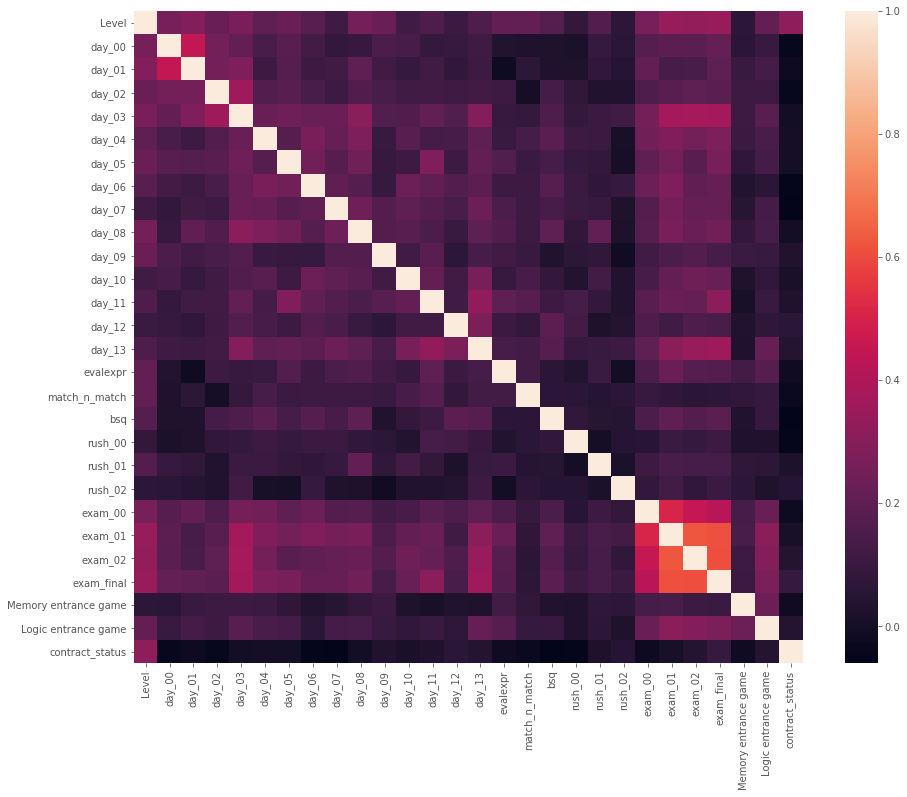

In [13]:
fig = plt.figure(figsize = (15, 12))
feat_correlation = df.drop(labels=['Wave id', 'Contract termination date'], axis=1).corr()
sns.heatmap(feat_correlation);

#### Check days features

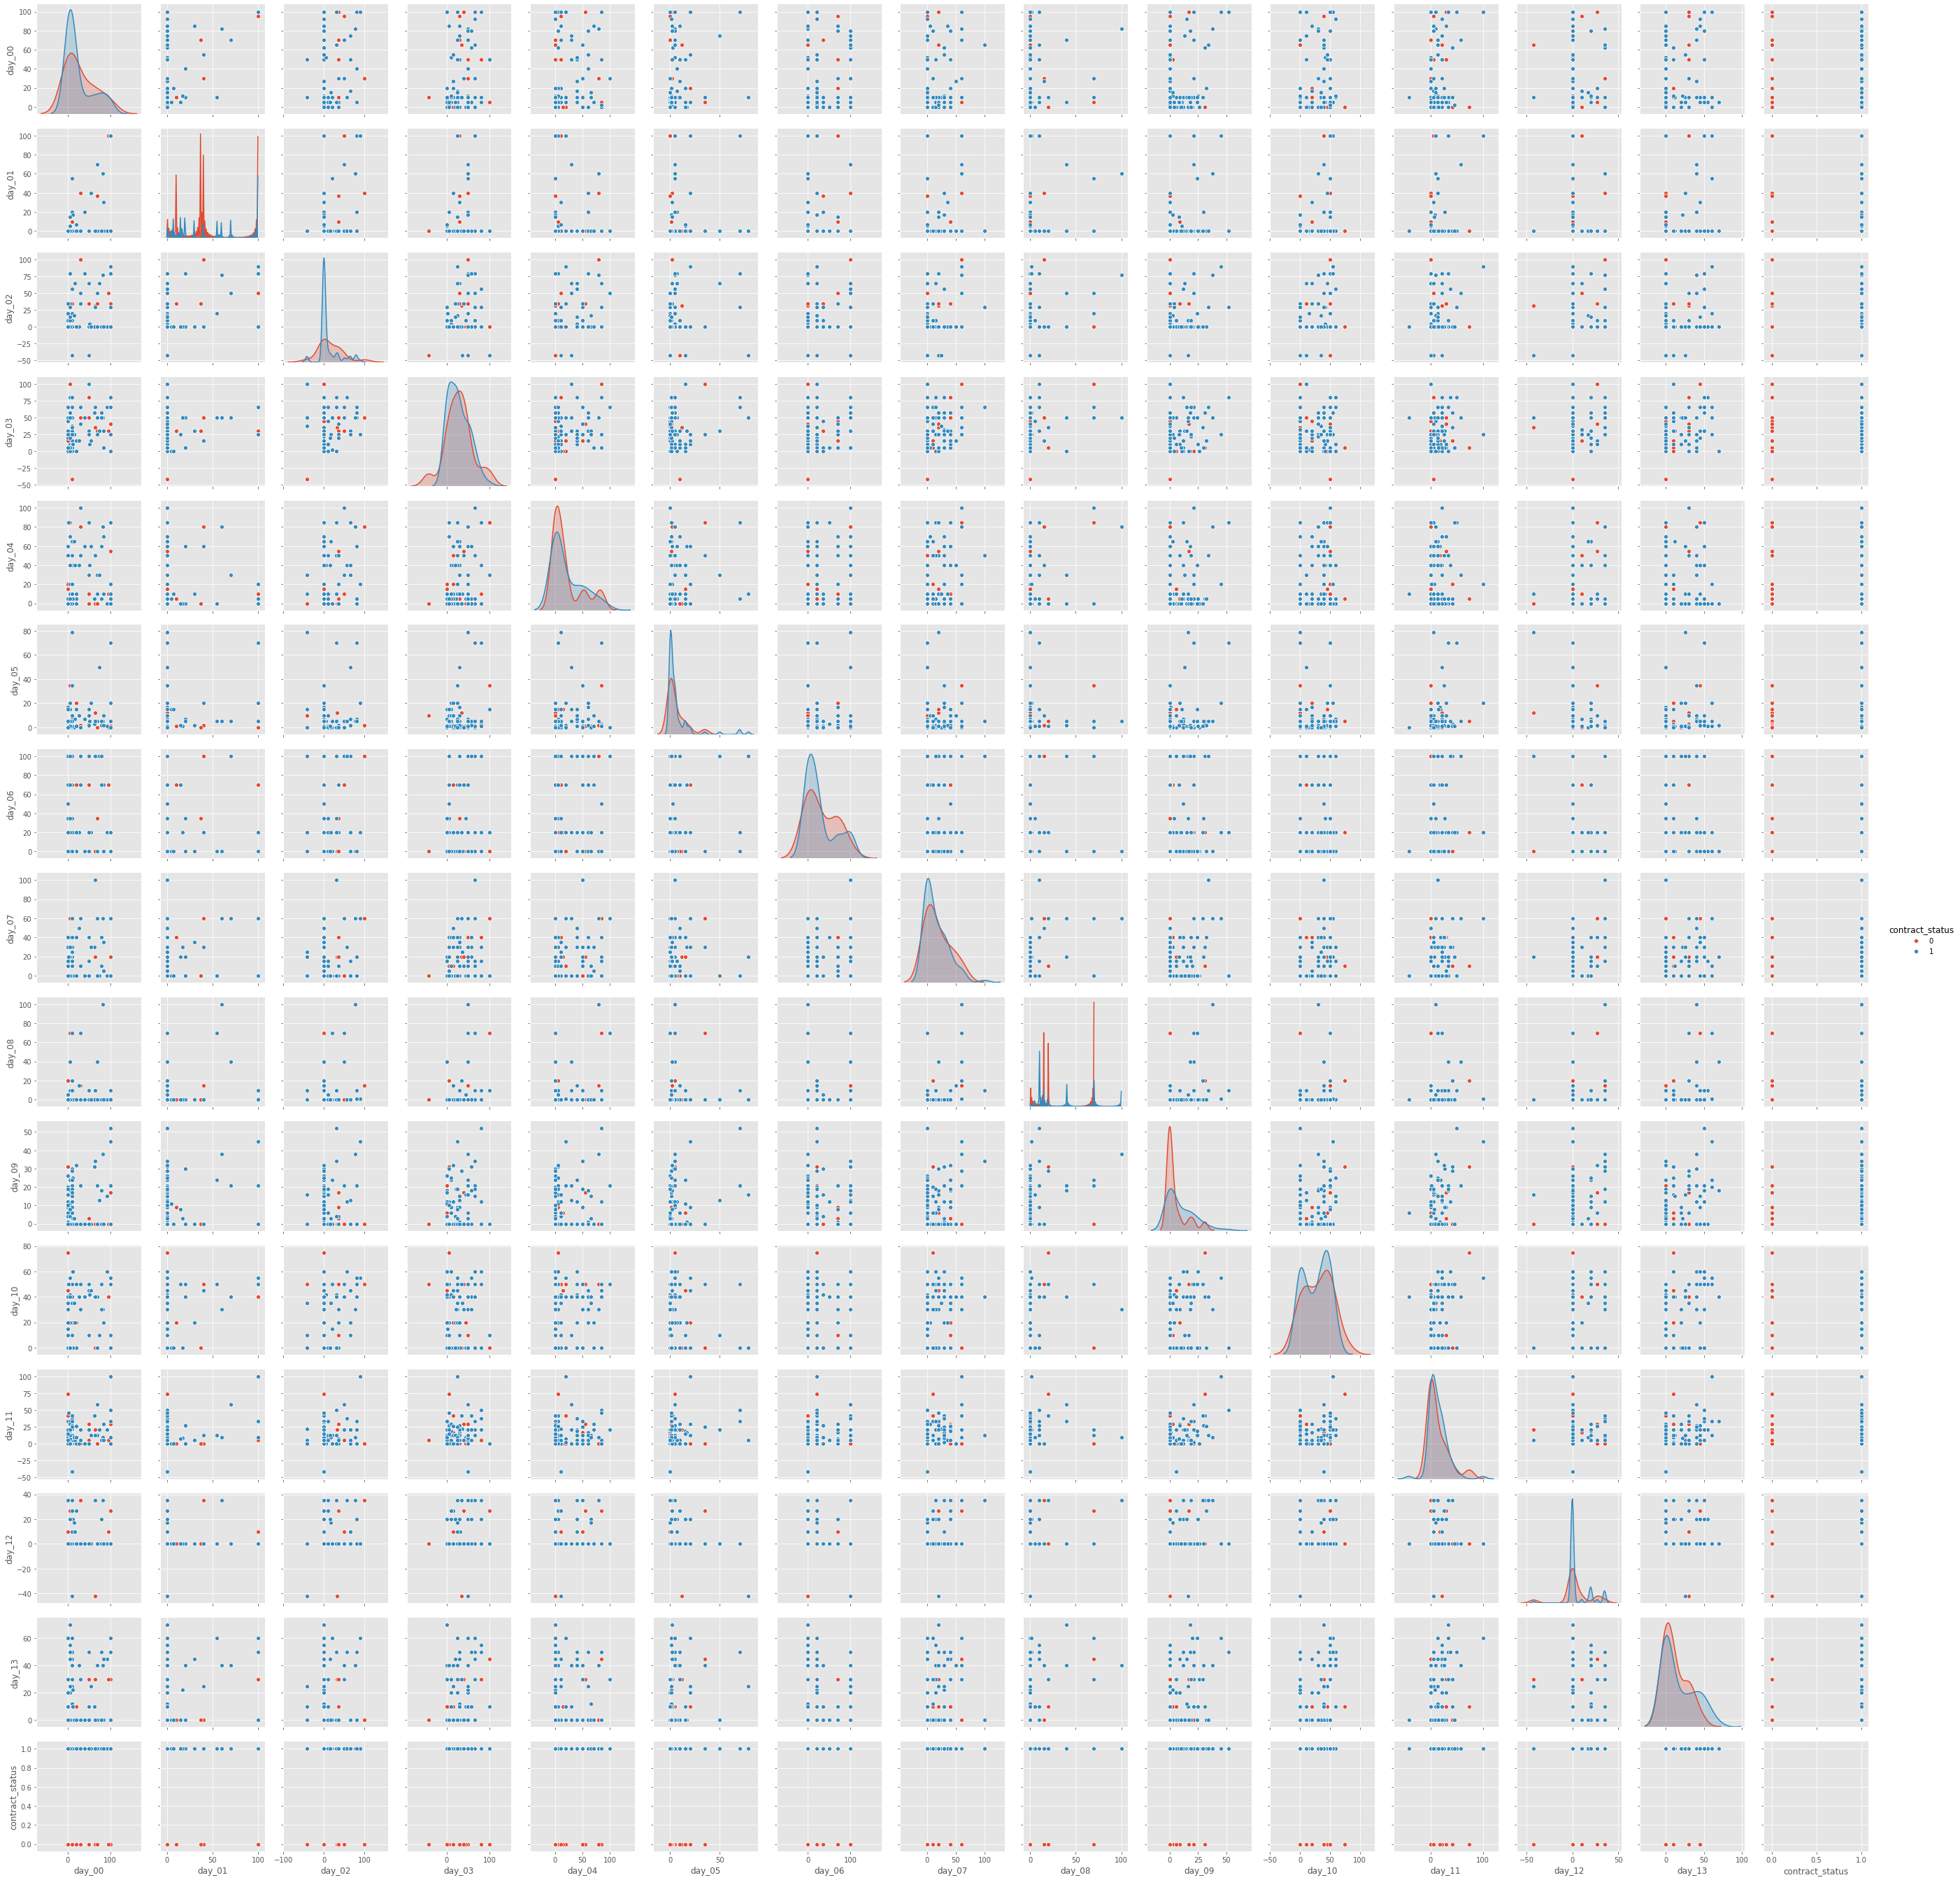

In [79]:
sns.pairplot(df[DAYS + ['contract_status']].iloc[:100, :].fillna(0), hue='contract_status');

#### Check exams features

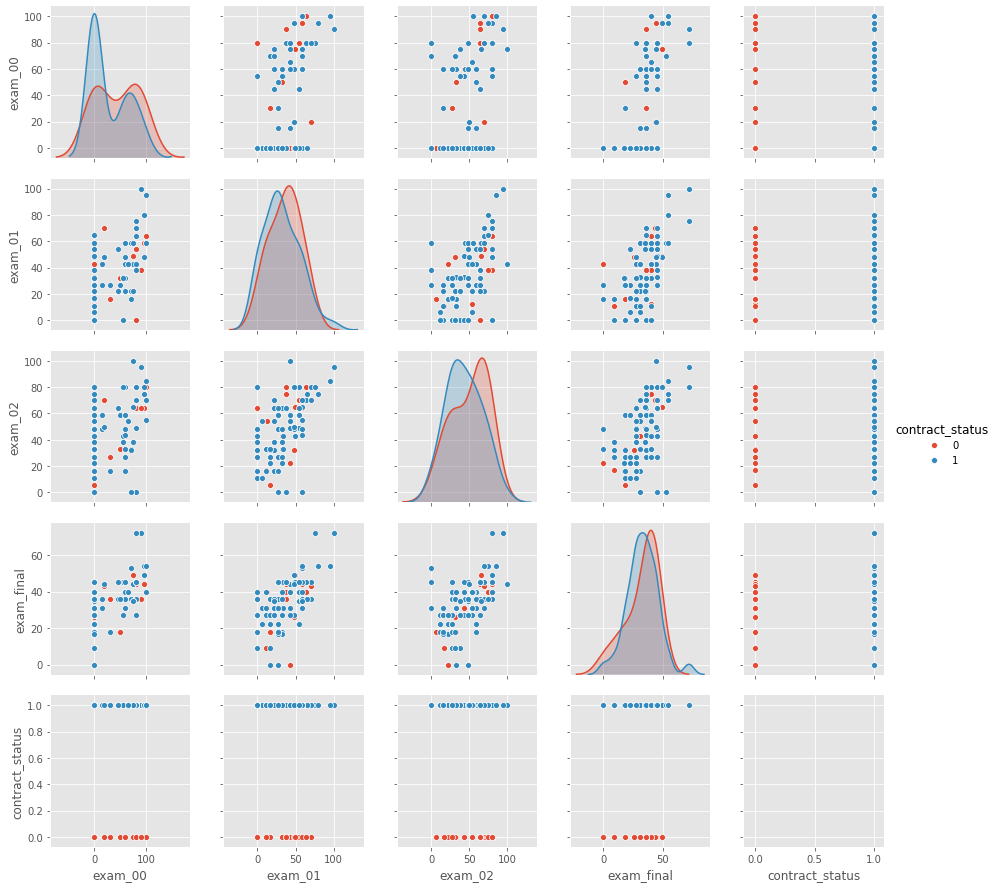

In [14]:
sns.pairplot(df[EXAMS + ['contract_status']].iloc[:100, :].fillna(0), hue='contract_status');

#### Check exam_00

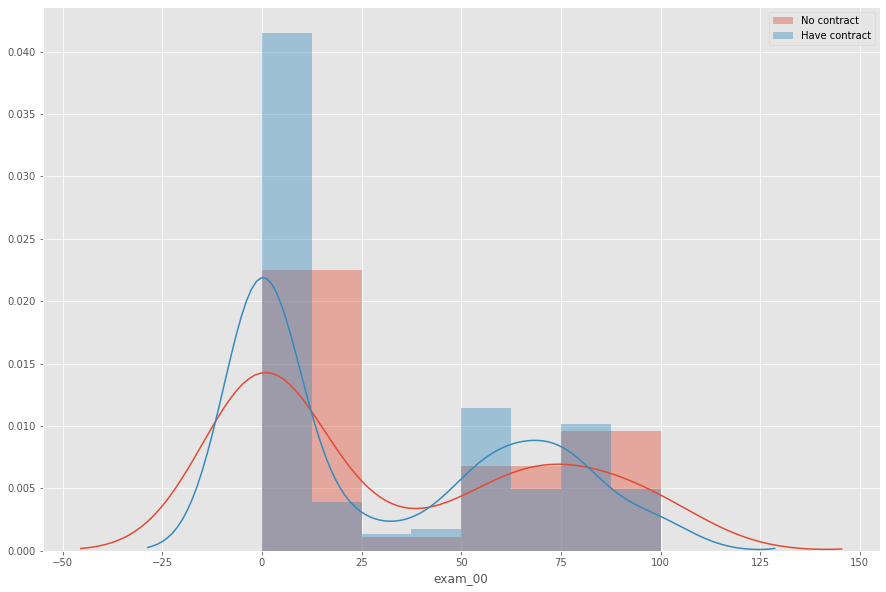

In [15]:
sns.distplot(df[df['contract_status'] == 0]['exam_00'].fillna(0), label='No contract')
sns.distplot(df[df['contract_status'] == 1]['exam_00'].fillna(0), label='Have contract')
plt.legend();

### Wave analysis

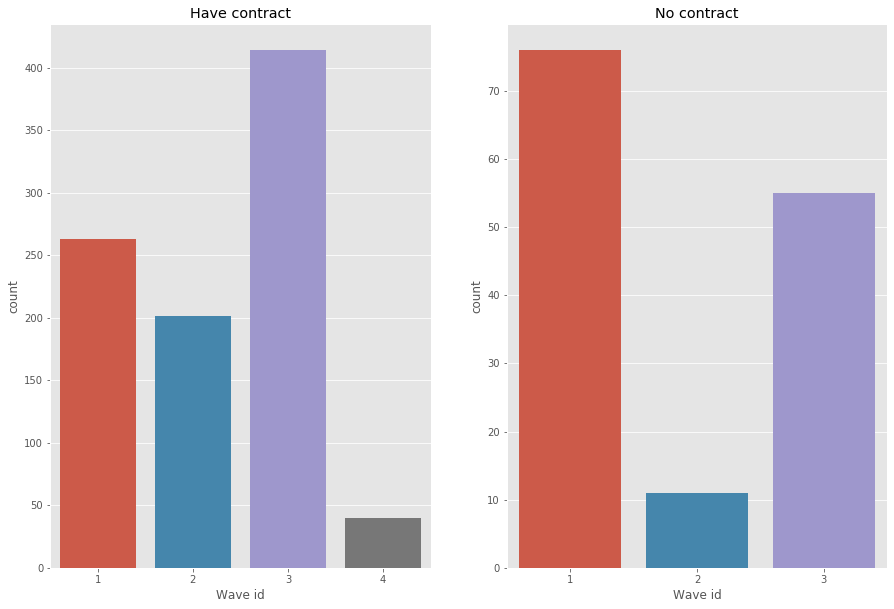

In [16]:
fig, axes = plt.subplots(1, 2)
sns.countplot(df[df['contract_status'] == 1]['Wave id'], ax=axes[0]).set_title('Have contract')
sns.countplot(df[df['contract_status'] == 0]['Wave id'], ax=axes[1]).set_title('No contract');

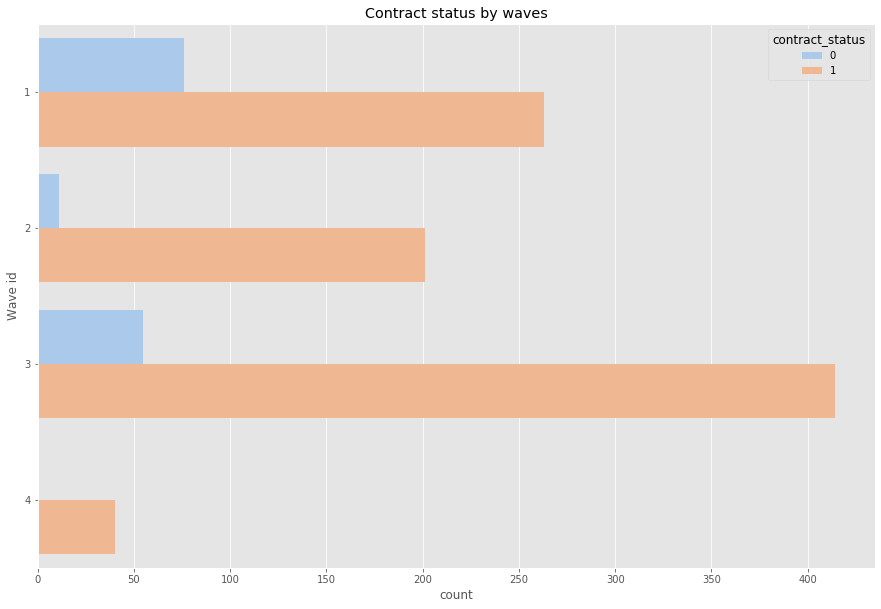

In [17]:
fig, axes = plt.subplots(1, 1, figsize=(15, 10))
sns.catplot(y="Wave id", hue="contract_status", kind="count", palette="pastel", data=df, ax=axes)
axes.set_title('Contract status by waves')
plt.close(2)

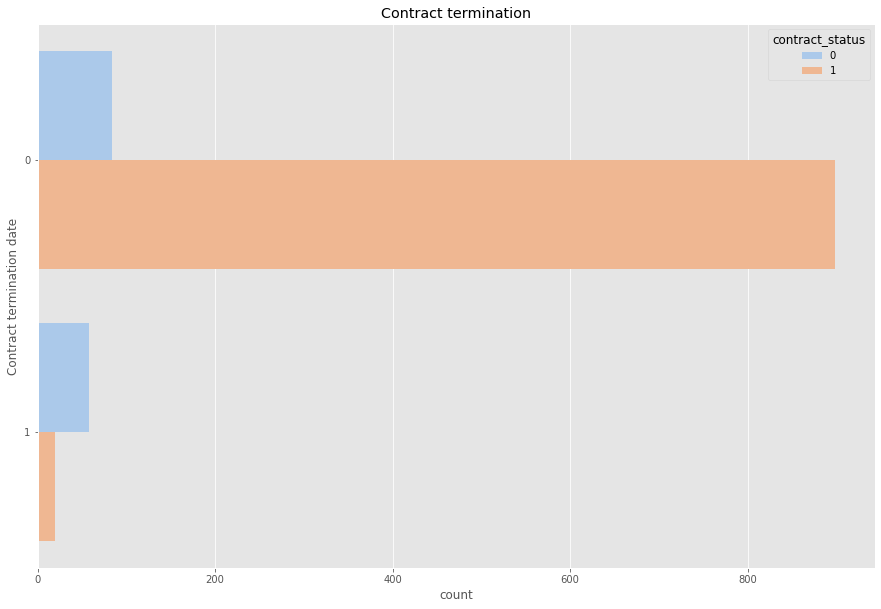

In [18]:
contract_term = df['Contract termination date'].notna().astype('int')
contract_term_df = pd.DataFrame(contract_term)
contract_term_df['contract_status'] = df['contract_status']
fig, axes = plt.subplots(1, 1, figsize=(15, 10))
sns.catplot(y='Contract termination date', hue='contract_status',
            data=contract_term_df, palette='pastel', kind='count', ax=axes)
axes.set_title('Contract termination')
plt.close(2)

### Level analysis

In [19]:
level_df = pd.DataFrame(df[['Wave id', 'Level', 'contract_status']])
level_df['Level'] = level_df['Level'].round().astype('int')

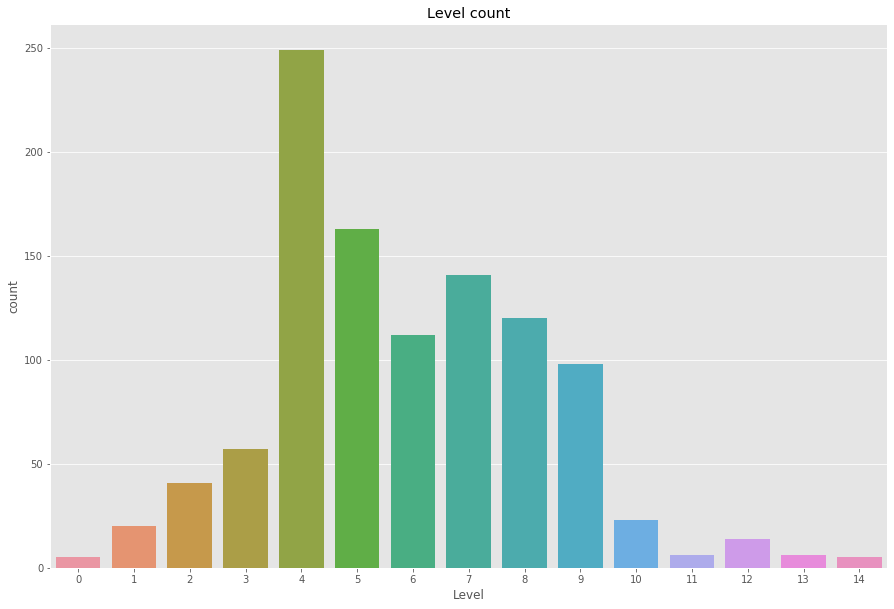

In [20]:
sns.countplot(level_df['Level']).set_title('Level count');

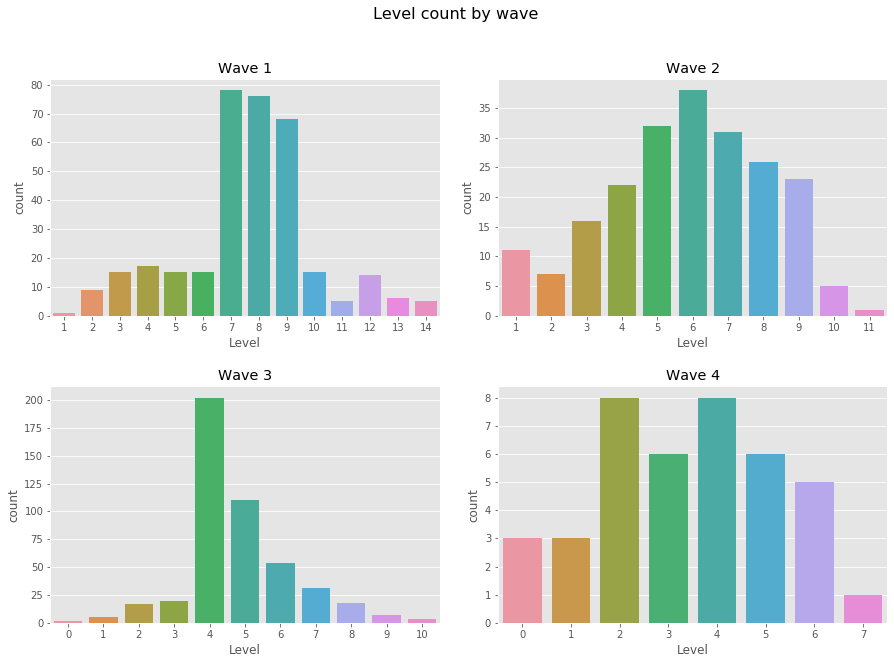

In [35]:
fig, axes = plt.subplots(2, 2)
n_wave = 1
for row_axes in axes:
    for ax in row_axes:
        sns.countplot(level_df[level_df['Wave id'] == n_wave]['Level'], ax=ax)
        ax.set_title(f'Wave {n_wave}')
        n_wave += 1
fig.suptitle('Level count by wave', fontsize=16)
# fig.tight_layout();
fig.subplots_adjust(wspace=0.15, hspace=0.3);

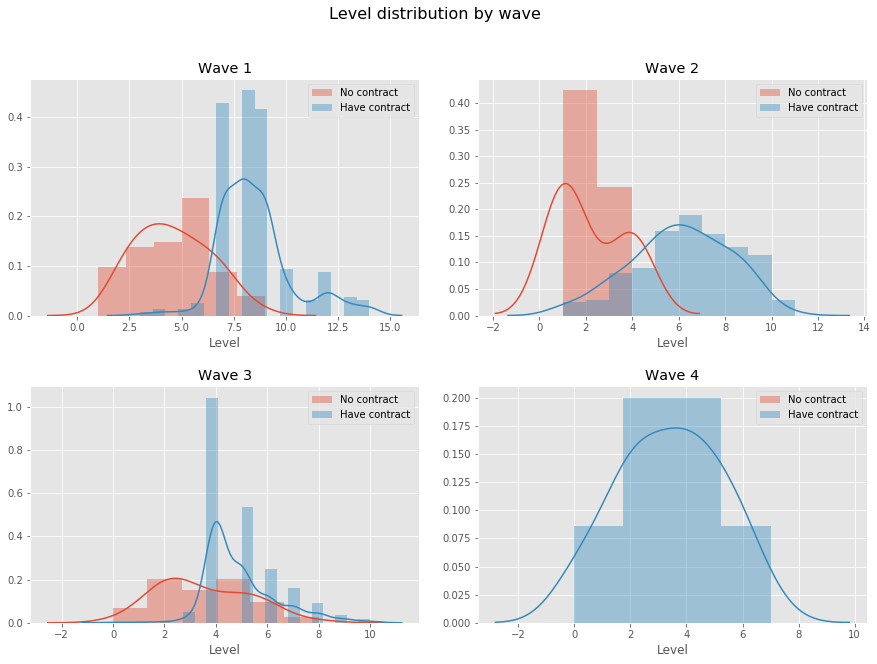

In [37]:
fig, axes = plt.subplots(2, 2)
n_wave = 1
for row_axes in axes:
    for ax in row_axes:
        sns.distplot(level_df[(level_df['Wave id'] == n_wave) & (level_df['contract_status'] == 0)]['Level'], ax=ax,
                    label='No contract')
        sns.distplot(level_df[(level_df['Wave id'] == n_wave) & (level_df['contract_status'] == 1)]['Level'], ax=ax,
                    label='Have contract')
        ax.set_title(f'Wave {n_wave}')
        ax.legend()
        n_wave += 1
fig.suptitle('Level distribution by wave', fontsize=16)
fig.subplots_adjust(wspace=0.15, hspace=0.3);

### Learning speed analysis

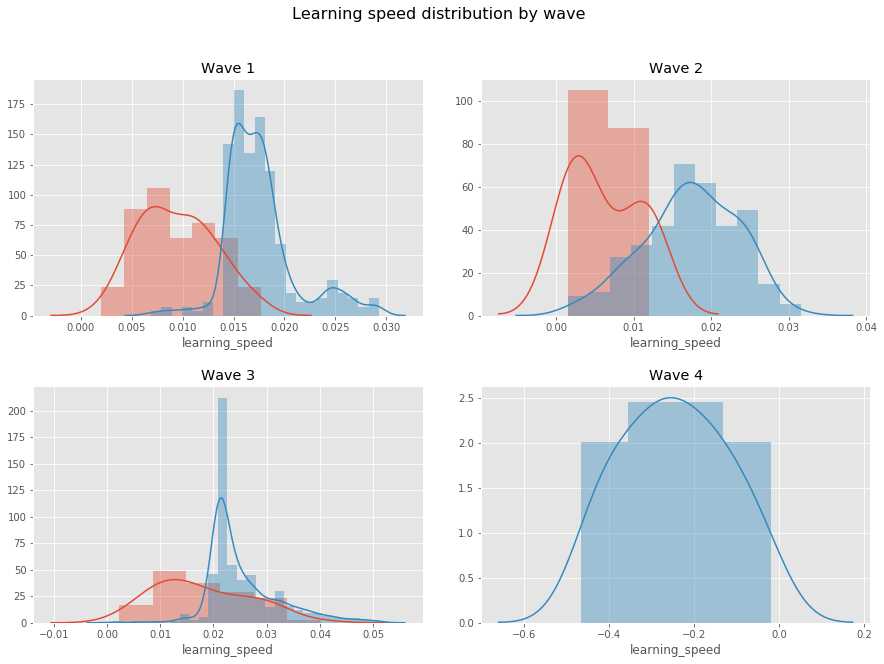

In [38]:
speed_df = pd.DataFrame(df[['contract_status', 'Wave id']])
speed_df['learning_speed'] = (df['Level'] / (pd.to_datetime('today') - pd.to_datetime(df['Wave id'].map(time_waves))).apply(lambda x: x.days))

n_wave = 1
fig, axes = plt.subplots(2, 2)
for row_axes in axes:
    for ax in row_axes:
        
        sns.distplot(speed_df[(speed_df['contract_status'] == 0) & (speed_df['Wave id'] == n_wave)]['learning_speed'],
                     label='No contract', ax=ax)
        sns.distplot(speed_df[(speed_df['contract_status'] == 1) & (speed_df['Wave id'] == n_wave)]['learning_speed'],
                     label='Have contract', ax=ax)
        ax.set_title(f'Wave {n_wave}')
        n_wave += 1
        
fig.suptitle('Learning speed distribution by wave', fontsize=16)
fig.subplots_adjust(wspace=0.15, hspace=0.3);

### Features generation

In [39]:
def proj_stats(df, proj):
    return pd.DataFrame([[sum(1 for _ in i[1].tolist() if _ < 0),
                          sum(1 for _ in i[1].tolist() if _ >= 0 and _ < 25),
                          sum(1 for _ in i[1].tolist() if _ >= 25)] for i in df.iterrows()],
                       columns=[f'{proj}_not_reg', f'{proj}_not_suc', f'{proj}_suc'])

def prepr(df):
    train_df = pd.DataFrame()
    train_df['Wave id'] = df['Wave id']
    train_df['speed_of_take_knowlege'] = (df['Level'] / (pd.to_datetime('today') - pd.to_datetime(df['Wave id'].map(time_waves))).apply(lambda x: x.days))
    train_df['years'] = pd.to_datetime(df['Birth date']).apply(lambda x: (2020 - x.year) if 2020 - x.year < 45 else 45)
    train_df['Contract termination date'] = pd.to_datetime(df['Contract termination date'].fillna('2020-03-15').apply(lambda x: x.partition('T')[0])).apply(lambda x: (pd.to_datetime('today') - x).days)
    train_df['exam'] = df[['exam_01', 'exam_02', 'exam_final']].fillna(-1).apply(lambda x: np.mean([j for j in x if j != -1]), axis=1)
    train_df['mean_day'] = df[[i for i in df.columns if 'day' in i]].fillna(-1).apply(lambda x: np.mean([j for j in x if j != -1]), axis=1)
    train_df['BSQ'] = df['bsq'].fillna(-1)
    
#     train_df['exams vs days'] = train_df['exam'] / (train_df['day_suc'] + 0.0001)
#     train_df['exams vs days sub'] = train_df['exam'] - (train_df['day_suc'])
    
    train_df['is_4_wave'] = df['Wave id'].apply(lambda x: x == 4).astype('int')
    train_df['cat_lvl'] = df['Level'].round().astype('int').astype('str')
    train_df['lvl + wave'] = df['Level'].round().astype('int').astype('str') + ' lvl + ' + df['Wave id'].astype('str') + ' wave'
    return train_df

target_df = df['contract_status']
train_df = prepr(df)
test_df = prepr(df_test)

### Split data (train/test) and fit first model

In [75]:
cat_features = ['Wave id', 'years', 'is_4_wave', 'cat_lvl', 'lvl + wave']
X_train, X_valid, y_train, y_valid = train_test_split(train_df, target_df, train_size=0.7, stratify=target_df)


train_data = Pool(X_train, label=y_train,
                  cat_features=cat_features,
                  feature_names=X_train.columns.to_list())

valid_data = Pool(X_valid, label=y_valid,
                  cat_features=cat_features,
                  feature_names=X_valid.columns.to_list())

params = {'iterations': 90,
          'learning_rate': 0.1,
          'cat_features': cat_features,
          'loss_function': 'Logloss',
          'verbose': False
         }

cbt_model1 = CatBoostClassifier(**params)
cbt_model1.fit(train_data, eval_set=valid_data)
print(cbt_model1.get_best_score())

# scores = cv(pool=data, params=params)
# cb = CatBoostClassifier(**params)
# cross_val_score(cb, train_df, target_df, cv=3, scoring='neg_log_loss')

{'learn': {'Logloss': 0.132455127342066}, 'validation': {'Logloss': 0.16455895279062568}}


#### Check score by cv

In [90]:
full_train = Pool(train_df, label=target_df, cat_features=cat_features, feature_names=train_df.columns.to_list())
scores = cv(pool=full_train, params=params, metric_period=10)

In [87]:
scores.tail()

iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
5          50           0.167574          0.025334            0.129029   
6          60           0.166822          0.024545            0.122594   
7          70           0.166345          0.024337            0.115806   
8          80           0.166643          0.024607            0.110313   
9          89           0.165056          0.025290            0.103180   

   train-Logloss-std  
5           0.014550  
6           0.011356  
7           0.011112  
8           0.010733  
9           0.008746

#### Feature importances

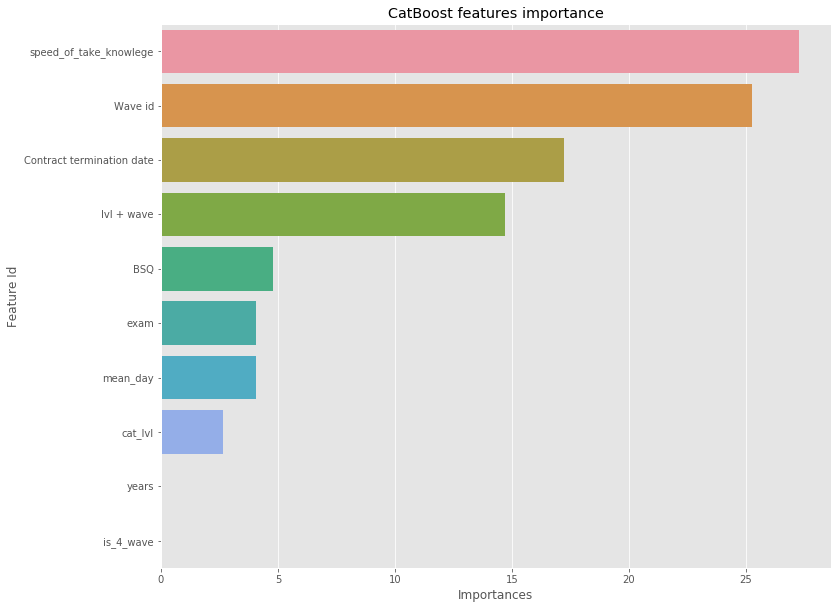

In [83]:
feature_importance_df = pd.DataFrame(cbt_model1.get_feature_importance(prettified=True),
                                     columns=['Feature Id', 'Importances'])
plt.figure(figsize=(12, 10))
sns.barplot(x='Importances', y='Feature Id', data=feature_importance_df)
plt.title('CatBoost features importance');

### Отбор фичей

In [105]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(cbt_model1, prefit=True)
train_selected = selector.transform(train_df)
train_selected_df = pd.DataFrame(data=train_df, index=train_df.index,
                              columns=train_df.columns[selector.get_support()])

In [106]:
train_selected_df.head()

Wave id  speed_of_take_knowlege  Contract termination date  \
id                                                                      
129212391        3                0.037884                          2   
566688420        1                0.018152                          2   
242300495        2                0.019302                          2   
715424753        1                0.016831                          2   
382884118        3                0.021689                          2   

               lvl + wave  
id                         
129212391  7 lvl + 3 wave  
566688420  9 lvl + 1 wave  
242300495  7 lvl + 2 wave  
715424753  8 lvl + 1 wave  
382884118  4 lvl + 3 wave

### First model and grid search

Может работать долго

In [120]:
from sklearn.model_selection import cross_val_score

cat_features = ['Wave id', 'lvl + wave']
params = {'iterations': 90,
          'learning_rate': 0.1,
          'cat_features': cat_features,
          'loss_function': 'Logloss',
          'verbose': False
         }

cb_model2 = CatBoostClassifier(**params)
cross_val_score(cb_model2, train_selected_df[['Wave id', 'speed_of_take_knowlege', 'Contract termination date', 'lvl + wave']], target_df, cv=5, scoring='neg_log_loss')

array([-0.14293918, -0.23398702, -0.17264472, -0.1674118 , -0.11132909])

In [136]:
depth = [i for i in range(1, 9)]

res = []
for i in depth:
    model_params = {'cat_features': cat_features,
                'loss_function': 'Logloss',
                'verbose': False,
                'iterations': 90,
                'depth': i}
    cb_model3 = CatBoostClassifier(**model_params)
    res.append(cross_val_score(cb_model3, train_selected_df, target_df))

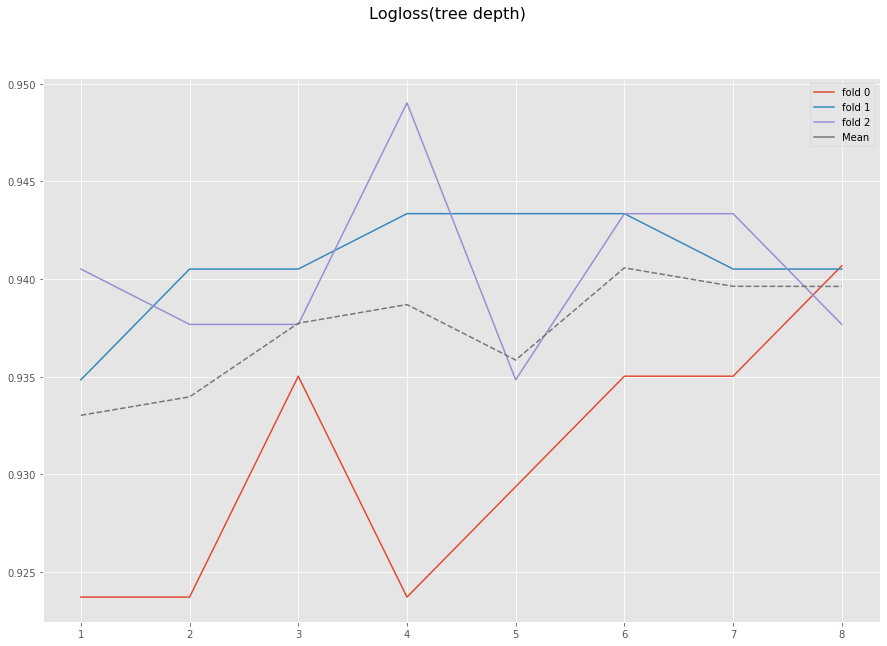

In [177]:
fig = plt.figure(figsize=(15, 10))
res = np.array(res)
for i in range(res.shape[1]):
    sns.lineplot(x=range(1, 9), y=res[:, i], label=f'fold {i}')
ax = sns.lineplot(x=range(1, 9), y=res.mean(axis=1), label='Mean', markers=True, dashes=False)
ax.lines[3].set_linestyle("--")
fig.suptitle('Logloss(tree depth)', fontsize=16);

In [164]:
learning_rates = np.geomspace(0.001, 0.9, 10)

learn_rate_res = []
for i in learning_rates:
    model_params = {'cat_features': cat_features,
                'loss_function': 'Logloss',
                'verbose': False,
                'depth': 4,
                'learning_rate': i}
    cb_model3 = CatBoostClassifier(**model_params)
    learn_rate_res.append(cross_val_score(cb_model3, train_selected_df, target_df))

In [198]:
grid_params = {'depth': [5],
               'iterations': [30, 200],
               'learning_rate': [0.1, 0.05, 0.001]}

cb_model3 = CatBoostClassifier(**model_params)


random_results = cb_model3.randomized_search(grid_params, X=train_selected_df, y=target_df, cv=3, shuffle=True, verbose=False)

In [192]:
model_params = {'cat_features': cat_features,
                'loss_function': 'Logloss',
                'verbose': False}
cb_model3 = CatBoostClassifier(**model_params)

grid_params = {'depth': [3, 10],
               'iterations': [30, 50, 100, 200],
               'learning_rate': [0.1, 0.01]}

grid_res = cb_model3.grid_search(grid_params, X=train_selected_df, y=target_df, cv=3, shuffle=True, verbose=False)

In [193]:
grid_res['params']

{'depth': 5, 'iterations': 100, 'learning_rate': 0.11}

### Predict and save

In [301]:
best_model = CatBoostClassifier(verbose=False,
                           loss_function='Logloss',
                           cat_features=['Wave id', 'Contract termination date', 'lvl + wave'],
                           depth=5,
                           iterations=90,
                           learning_rate=0.1)

best_model.fit(train_selected_df, target_df)
y_pred = best_model.predict_proba(test_df[train_selected_df.columns])

In [246]:
tmp = pd.DataFrame(test_df[train_selected_df.columns], index=test_df.index)

In [247]:
tmp['predict'] = y_pred[:, 1]

### Так делать плохо

In [310]:
tmp.loc[tmp['Wave id'] == 4, 'predict'] = 1
tmp.loc[tmp['lvl + wave'] == '9 lvl + 2 wave', 'predict'] = 1
tmp.loc[tmp['lvl + wave'] == '12 lvl + 1 wave', 'predict'] = 1
tmp.loc[tmp['lvl + wave'] == '13 lvl + 1 wave', 'predict'] = 1
tmp.loc[tmp['lvl + wave'] == '15 lvl + 1 wave', 'predict'] = 1
tmp.loc[tmp['lvl + wave'] == '9 lvl + 3 wave', 'predict'] = 1
tmp.loc[tmp['lvl + wave'] == '11 lvl + 1 wave', 'predict'] = 1

In [311]:
tmp.head()

contract_status  Wave id      lvl + wave
id                                                  
685512434          1.000000        3  9 lvl + 3 wave
157712083          0.973813        2  2 lvl + 2 wave
672158583          0.851937        3  4 lvl + 3 wave
1205321261         0.994332        2  6 lvl + 2 wave
621191476          0.979607        1  7 lvl + 1 wave

### Save submission

In [312]:
submission = pd.DataFrame(index=tmp.index)
submission['contract_status'] = tmp['contract_status']

In [314]:
submission.to_csv('submission5.csv')